In [1]:
%reload_ext autoreload
%autoreload 2
from scrape_GR_tools import *
from scrape_explore import *
#put this in scrape_GR_tools
import pandas as pd

import graphlab as gl

import networkx as nx
import nxpd as nxpd
from IPython.display import display, Image
import community

from datetime import date, datetime
grDateFormat = '%b %d, %Y'

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors

This non-commercial license of GraphLab Create for academic use is assigned to ref302@nyu.edu and will expire on October 13, 2017.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1479678132.log


In [382]:
with open('focalbook.txt') as f:
    focalBookID = int(f.next())
    focalBookCollectionTag = f.next().rstrip()

focalBookInfo = bookTitle(focalBookID)
print 'Focal book: %d (%s), with %d ratings' %(focalBookID, focalBookInfo[0], focalBookInfo[1])
#exploreFromBook(focalBookID, ratingsFromBook, friendsFromBook, booksFromBook, 0.05)

Focal book: 6759 (Infinite Jest), with 51175 ratings


In [383]:
# setting up mongodb

client = MongoClient('mongodb://localhost:27017/')

db = client['goodreads_explore_multigraph']

friendsUnbiased = db['friends']
ratingsUnbiased = db['reviews']
booksUnbiased = db['books']

dbBiased = client['goodreads_explore_multigraph_biased_sampling']

friendsBiased = dbBiased['friends']
ratingsBiased = dbBiased['reviews']
booksBiased = dbBiased['books']

dbFromBook = client['goodreads_explore_from_book_' + focalBookCollectionTag]

friendsFromBook = dbFromBook['friends']
ratingsFromBook = dbFromBook['reviews']
booksFromBook = dbFromBook['books']

dbSnowball = client['goodreads_snowball']
friendsSnowball = dbSnowball['friends']
ratingsSnowball = dbSnowball['reviews']
booksSnowball = dbSnowball['books']

In [836]:
checkBiased = False
checkFromBook = False
checkSnowball = False
checkFull = True

In [864]:
# checking what we've got

if checkBiased:
    friends = friendsBiased
    ratings = ratingsBiased
    books = booksBiased
elif checkFromBook:
    friends = friendsFromBook
    ratings = ratingsFromBook
    books = booksFromBook
elif checkSnowball:
    friends = friendsSnowball
    ratings = ratingsSnowball
    books = booksSnowball
elif checkFull:
    friends = friendsFull
    ratings = ratingsFull
    books = booksFull

else:
    friends = friendsUnbiased
    ratings = ratingsUnbiased
    books = booksUnbiased

print '%d users' % ratings.count()
print '%d books' % books.count()
print '%d users have scraped friend lists\n' % friends.count()

if ratings.count() > 0:
    t = books.find()
    countList = []

    for b in t:
        countList.append(len(b['ratings']))

    clS = pd.Series(countList)
        
    print '%.2f%% of books have >1 ratings' % float(100*(clS>1).mean())
    print '(%d books)\n' %(clS>1).sum()

    print '%.2f%% of books have >2 ratings' % float(100*(clS>2).mean())
    print '(%d books)\n' %(clS>2).sum()

    print '%.2f%% of books have >5 ratings' % float(100*(clS>5).mean())
    print '(%d books)\n' %(clS>5).sum()

    print '%.2f%% of books have >10 ratings' % float(100*(clS>10).mean())
    print '(%d books)\n' %(clS>10).sum()

    print 'Descriptive statistics for ratings:'
    print clS.describe()

355 users
67871 books
3607 users have scraped friend lists

16.64% of books have >1 ratings
(11292 books)

7.01% of books have >2 ratings
(4761 books)

1.95% of books have >5 ratings
(1324 books)

0.69% of books have >10 ratings
(469 books)

Descriptive statistics for ratings:
count    67871.000000
mean         1.450914
std          2.328586
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        119.000000
dtype: float64


In [305]:
nUserCounts = []
for i, row in enumerate(ratings.find()):
    nUserCounts.append(len(row['ratings']))
    
nBookCounts = []
bookIDlist = []
for i, row in enumerate(books.find()):
    nBookCounts.append(len(row['ratings']))
    bookIDlist.append(row['bookID'])

In [306]:
'''
for index in np.argsort(nBookCounts)[::-1][20:]:
    print (bookTitle(bookIDlist[index]),nBookCounts[index])
'''

'\nfor index in np.argsort(nBookCounts)[::-1][20:]:\n    print (bookTitle(bookIDlist[index]),nBookCounts[index])\n'

In [294]:
nUserCounts = pd.Series(nUserCounts)
print (nUserCounts < 10).mean()

nBookCounts = pd.Series(nBookCounts)
print (nBookCounts < 2).mean()

bookIDlist = pd.Series(bookIDlist)
booksToExclude = set(bookIDlist[nBookCounts < 10])
print (nBookCounts >= 10).sum()

0.0226781857451
0.762953701671
2714


In [221]:
nBookCounts[nBookCounts>=10].describe()

count    478.000000
mean      17.248954
std        8.746053
min       10.000000
25%       11.000000
50%       14.000000
75%       20.000000
max       86.000000
dtype: float64

In [222]:
nUserCounts.describe()

count      105.000000
mean       624.942857
std       1358.742234
min         16.000000
25%        121.000000
50%        253.000000
75%        627.000000
max      12547.000000
dtype: float64

In [56]:
targetRatings = books.find_one({'bookID': focalBookID})['ratings']
targetRatingDates = np.array([datetime.strptime(r[2], grDateFormat) for r in targetRatings.values()])
#strictCutoff = min(targetRatingDates)
#print strictCutoff.strftime(grDateFormat)
print len(targetRatingDates)
print sum(targetRatingDates > datetime.strptime('Jan 1, 2014', grDateFormat)) / float(len(targetRatingDates))
cutoffDate = datetime.strptime('Jan 1, 2014', grDateFormat)
todayDate = date.today()
today = datetime(todayDate.year, todayDate.month, todayDate.day)

291
0.250859106529


In [608]:
glRatingDict = makeRatingDictForGL(ratings, booksToExclude)
glRatings = gl.SFrame(glRatingDict)

In [609]:
glRatingsTrain, glRatingsTest = gl.recommender.util.random_split_by_user(glRatings, 
                                                    user_id="userID", 
                                                    item_id="bookID")

In [883]:
nTrainObs = glRatingsTrain.shape[0]
nTrainUsers = len(glRatingsTrain['userID'].unique())
nTrainItems = len(glRatingsTrain['bookID'].unique())

print nTrainObs, nTrainUsers, nTrainItems

for n in range(1,6):
    print nTrainObs / (n*float(nTrainUsers + nTrainItems))

24035 334 1710
11.7588062622
5.87940313112
3.91960208741
2.93970156556
2.35176125245


In [8]:
#cutoff date based

#glRatingDictTrain = makeRatingDictForGL(ratings, cutoffDate)
#glRatingsTrain = gl.SFrame(glRatingDictTrain)
#glRatingDictTest = makeRatingDictForGL(ratings, cutoffDate, upperBound=False)
#glRatingsTest = gl.SFrame(glRatingDictTest)

In [360]:
models = gl.toolkits.model_parameter_search.create((glRatingsTrain, glRatingsTest),
                                                     gl.factorization_recommender.create,
                                                     {'user_id': 'userID',
                                                      'item_id': 'bookID',
                                                      'target': 'rating',
                                                      'num_factors': 1,
                                                      'max_iterations': 1000
                                                      })

[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.job: Creating a LocalAsync environment called 'async'.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Nov-21-2016-17-01-3300000' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Nov-21-2016-17-01-3300000' scheduled.
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: A job with name 'Model-Parameter-Search-Nov-21-2016-17-01-3300000' already exists. Renaming the job to 'Model-Parameter-Search-Nov-21-2016-17-01-3300000-5c298'.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Nov-21-2016-17-01-3300000-5c298' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Nov-21-2016-17-01-3300000-5c298' scheduled.


In [426]:
models.get_results().sort('validation_rmse')

model_id,item_id,linear_regularization,max_iterations,num_factors,regularization,target,user_id
7,bookID,1e-05,1000,1,0.0001,rating,userID
4,bookID,1e-05,1000,1,1e-07,rating,userID
6,bookID,1e-07,1000,1,1e-07,rating,userID
9,bookID,1e-05,1000,1,1e-09,rating,userID
5,bookID,1e-07,1000,1,1e-07,rating,userID
2,bookID,1e-05,1000,1,1e-09,rating,userID
8,bookID,1e-09,1000,1,1e-07,rating,userID
3,bookID,1e-09,1000,1,1e-09,rating,userID
1,bookID,1e-07,1000,1,1e-06,rating,userID
0,bookID,1e-07,1000,1,0.0001,rating,userID


In [884]:
rec_engine_baseline = gl.factorization_recommender.create(   observation_data=glRatingsTrain, 
                                                    user_id="userID", 
                                                    item_id="bookID", 
                                                    target='rating',
                                                    num_factors=0,
                                                    solver='auto',
                                                    max_iterations=200,
                                                    regularization = 0.0001,
                                                    linear_regularization = 1e-2
                                                    )

Recsys training: model = factorization_recommender

Preparing data set.

Data has 24035 observations with 334 users and 1710 items.

Data prepared in: 0.110777s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 0        |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 200      |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 24035 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.306095          | No Decrease (1.02682 >= 0.995956)        |

| 1       | 0.0765237         | 0.979875                                 |

| 2       | 0.0382619         | 0.971949                                 |

| 3       | 0.0191309         | 0.965455                                 |

| 4       | 0.00956546        | 0.956827                                 |

| 5       | 0.00478273        | 0.948526                                 |

| 6       | 0.00239137        | 0.941878                                 |

| 7       | 0.00119568        | 0.943008                                 |

| 8       | 0.000597841       | 0.956177                                 |

| 9       | 0.000298921       | 0.971015                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.00239137        | 0.941878                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 80us         | 0.989945          | 0.994959              |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 612.942ms    | 0.973543          | 0.968997              | 0.00239137  |

| 2       | 1.23s        | 0.951423          | 0.948269              | 0.00142191  |

| 3       | 1.82s        | 0.94867           | 0.942337              | 0.00104907  |

| 4       | 2.42s        | 0.948584          | 0.939554              | 0.000845476 |

| 5       | 3.02s        | 0.949371          | 0.938069              | 0.000715185 |

| 6       | 3.64s        | 0.949064          | 0.936797              | 0.000524536 |

| 10      | 6.05s        | 0.949077          | 0.934919              | 0.000178796 |

| 11      | 6.67s        | 0.949341          | 0.934822              | 0.000166462 |

| 15      | 9.10s        | 0.949278          | 0.934302              | 6.59569e-05 |

| 20      | 12.16s       | 0.949285          | 0.934098              | 2.23495e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 0.94963

Final training RMSE: 0.934283

In [885]:
rec_engine_baseline.evaluate_rmse(glRatingsTest, target='rating')['rmse_overall']

0.9429183755691091

In [711]:
rec_engine_1 = gl.factorization_recommender.create(   observation_data=glRatingsTrain, 
                                                    user_id="userID", 
                                                    item_id="bookID", 
                                                    target='rating',
                                                    num_factors=2,
                                                    solver='auto',
                                                    max_iterations=200,
                                                    regularization = 0.001,
                                                    linear_regularization = 1e-2
                                                    )

Recsys training: model = factorization_recommender

Preparing data set.

Data has 1519 observations with 57 users and 242 items.

Data prepared in: 0.049278s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 2        |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 200      |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 1519 / 1519 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 4.73497           | 0.841782                                 |

| 1       | 2.36748           | 0.857659                                 |

| 2       | 1.18374           | 0.9245                                   |

| 3       | 0.591871          | 0.915911                                 |

+---------+-------------------+------------------------------------------+

| Final   | 4.73497           | 0.841782                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 65us         | 0.980252          | 0.990077              |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 148.306ms    | DIVERGED          | DIVERGED              | 4.73497     |

| RESET   | 162.899ms    | 0.980256          | 0.990079              |             |

| 1       | 303.209ms    | DIVERGED          | DIVERGED              | 2.36748     |

| RESET   | 319.4ms      | 0.980256          | 0.990079              |             |

| 1       | 457.805ms    | DIVERGED          | DIVERGED              | 1.18374     |

| RESET   | 471.558ms    | 0.980256          | 0.990079              |             |

| 1       | 611.068ms    | DIVERGED          | DIVERGED              | 0.591871    |

| RESET   | 623.275ms    | 0.980256          | 0.990079              |             |

| 1       | 777.244ms    | 1.60354           | 1.08842               | 0.295936    |

| 2       | 907.644ms    | 1.05204           | 0.939451              | 0.0538529   |

| 3       | 1.03s        | 0.93385           | 0.883409              | 0.0296216   |

| 4       | 1.17s        | 0.905554          | 0.867341              | 0.020166    |

| 5       | 1.30s        | 0.893365          | 0.860365              | 0.0154372   |

| 6       | 1.44s        | 0.879811          | 0.853076              | 0.0125049   |

| 11      | 2.08s        | 0.850674          | 0.834511              | 0.00641361  |

| 16      | 2.72s        | 0.818859          | 0.813919              | 0.00431279  |

| 26      | 4.02s        | 0.767292          | 0.77675               | 0.00260574  |

| 36      | 5.32s        | 0.73515           | 0.751902              | 0.00186683  |

| 46      | 6.65s        | 0.71463           | 0.735214              | 0.0014544   |

| 51      | 7.34s        | 0.707108          | 0.728844              | 0.00130973  |

| 56      | 8.00s        | 0.700757          | 0.723379              | 0.00119123  |

| 66      | 9.30s        | 0.690465          | 0.714284              | 0.00100871  |

| 76      | 10.62s       | 0.682213          | 0.706889              | 0.000874685 |

| 86      | 11.94s       | 0.675633          | 0.70083               | 0.0007721   |

| 96      | 13.22s       | 0.670262          | 0.69578               | 0.000691052 |

| 101     | 13.86s       | 0.667728          | 0.693409              | 0.000656591 |

| 106     | 14.50s       | 0.665588          | 0.69134               | 0.000625403 |

| 116     | 15.79s       | 0.66154           | 0.687433              | 0.000571145 |

| 126     | 17.12s       | 0.658036          | 0.683989              | 0.00052555  |

| 136     | 18.40s       | 0.655024          | 0.680974              | 0.000486697 |

| 146     | 19.69s       | 0.652332          | 0.67825               | 0.000453192 |

| 156     | 20.99s       | 0.649814          | 0.675696              | 0.000424004 |

| 166     | 22.31s       | 0.647563          | 0.673382              | 0.000398348 |

| 176     | 23.59s       | 0.645566          | 0.671296              | 0.00037562  |

| 186     | 24.88s       | 0.643644          | 0.669298              | 0.000355345 |

| 196     | 26.19s       | 0.64195           | 0.667495              | 0.000337147 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.640934

Final training RMSE: 0.666528

In [712]:
print rec_engine_1.evaluate_rmse(glRatingsTest, target='rating')['rmse_overall']
print rec_engine_1.evaluate_rmse(glRatingsTest, target='rating')['rmse_overall'] - rec_engine_baseline.evaluate_rmse(glRatingsTest, target='rating')['rmse_overall']

0.972892212076
0.0368216925111


In [750]:
friendCounts = []
userIDlist = []

for f in friends.find():
    userIDlist.append(f['userID'])
    
userIDset = set(userIDlist)

for f in friends.find():
    friendCounts.append(len(set(f['friends']) & userIDset))

In [751]:
friendCounts = pd.Series(friendCounts)
friendCounts.describe()

count    3592.000000
mean        5.146993
std        14.493936
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max       151.000000
dtype: float64

In [752]:
(friendCounts > 0).sum()

1932

In [753]:
adj_dict = {}
for f in friends.find():
    curFlist = set(f['friends'])
    friendsInData = curFlist & set(userIDlist)
    if len(friendsInData) > 0:
        adj_dict[f['userID']] = list(friendsInData)

In [754]:
len(adj_dict)

1733

In [755]:
g = nx.from_dict_of_lists(adj_dict)

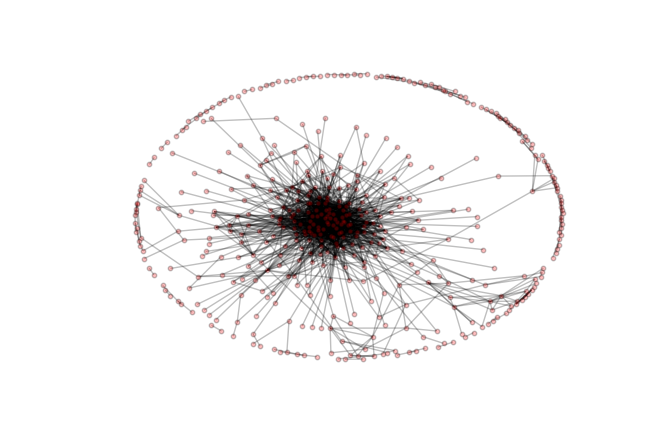

In [23]:
nx.draw(g, node_size=10, alpha=0.25)

In [522]:
commDict = community.best_partition(g)
#colorDict = {k: min(v+1,11) + int(v>11) for k, v in commDict.items()}
colorNames = colors.cnames.keys()
colorDict = {k: colorNames[v] for k, v  in commDict.items()}

In [402]:
g.graph['overlap']='True'

nx.set_node_attributes(g, 'color', colorDict)
nx.set_node_attributes(g, 'colorscheme', 'svg')
nx.set_node_attributes(g, 'style', 'filled')

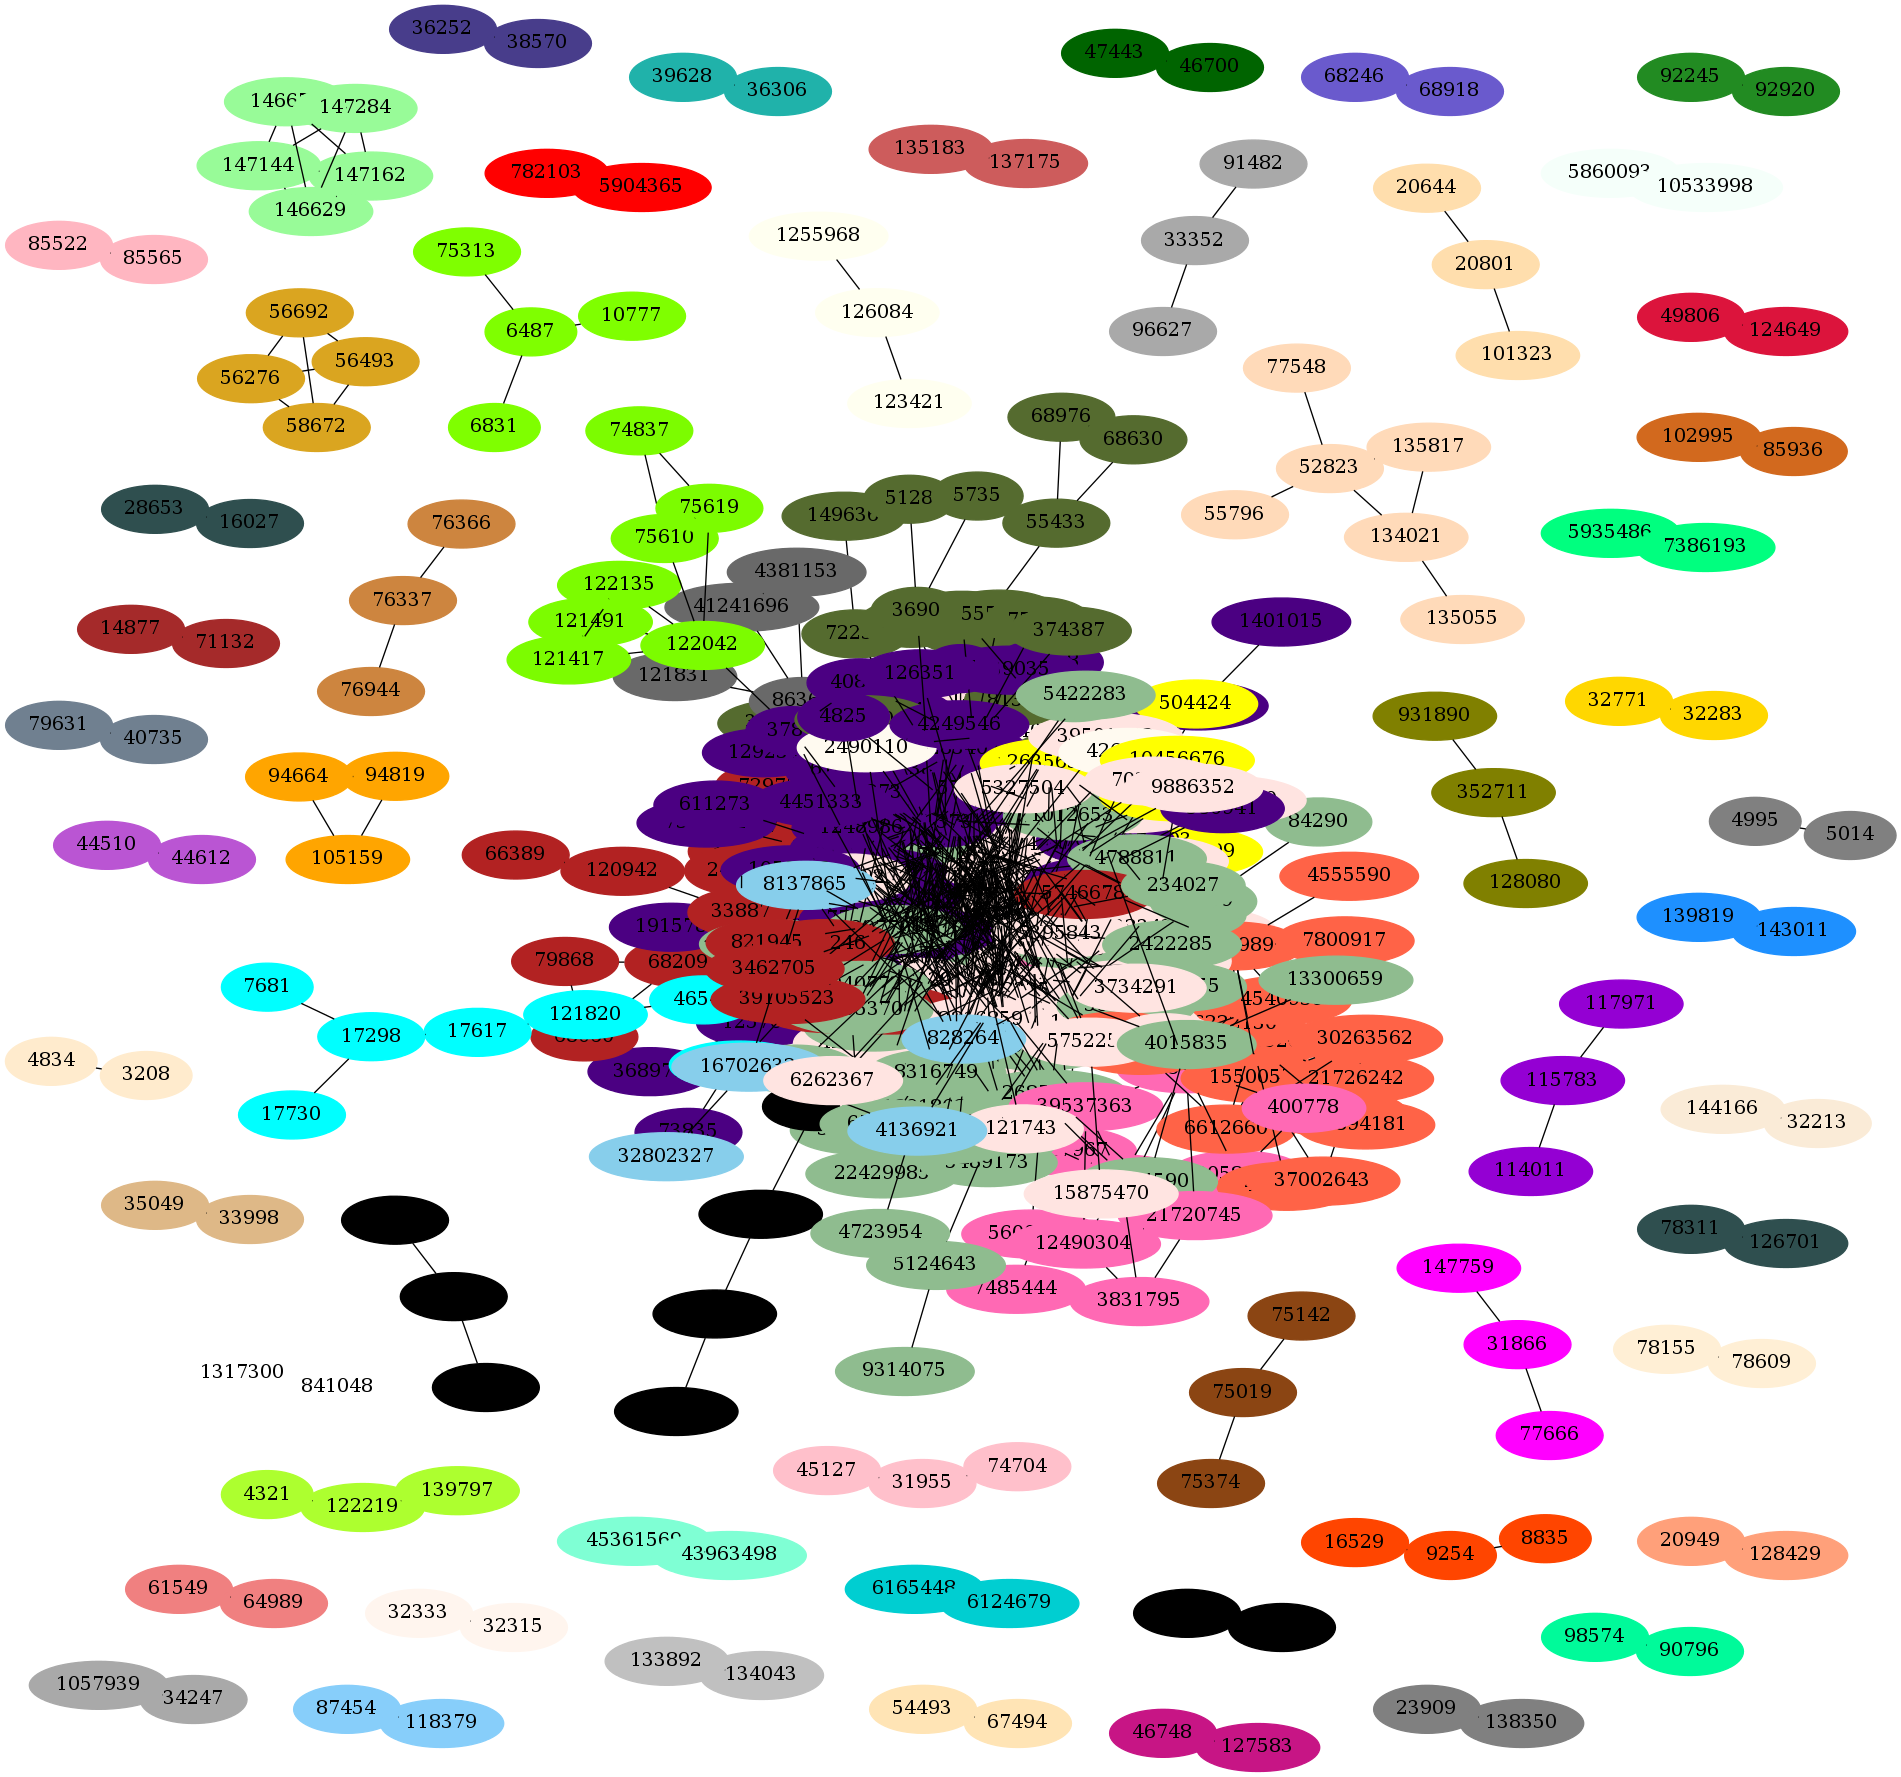

In [27]:
nxpd.draw(g, layout='neato', show='ipynb')

In [756]:
communityNodes = [nodes for nodes in nx.connected_components(g)]
#communityNodes = \
#[[uID for uID in commDict if commDict[uID] == i] for i in range(max(commDict.values()))]

In [757]:
communitySizes = [len(nodes) for nodes in communityNodes]

In [758]:
commsOfInterest = [(i, communitySizes[i]) for i in range(len(communitySizes))\
                   if communitySizes[i] > 2 and communitySizes[i] < 30]
commsOfInterest

[(0, 4),
 (3, 3),
 (4, 3),
 (8, 3),
 (10, 5),
 (11, 7),
 (13, 3),
 (14, 14),
 (15, 3),
 (17, 3),
 (19, 3),
 (20, 3),
 (24, 3),
 (26, 3),
 (27, 3),
 (31, 5),
 (33, 7),
 (34, 3),
 (38, 5),
 (40, 3),
 (45, 5),
 (48, 3),
 (52, 3),
 (54, 3),
 (60, 9),
 (61, 6),
 (63, 3),
 (65, 3),
 (66, 3),
 (68, 3),
 (82, 6),
 (91, 4),
 (103, 3),
 (106, 3),
 (107, 3),
 (109, 4),
 (110, 3),
 (115, 3),
 (116, 9),
 (119, 4),
 (120, 3),
 (126, 3),
 (128, 4),
 (129, 3),
 (132, 5),
 (138, 3),
 (140, 3),
 (141, 3),
 (148, 3),
 (151, 3),
 (156, 3),
 (166, 3),
 (175, 3),
 (179, 5)]

0
{94664: 0.6666666666666666, 94819: 1.0, 93646: 1.0, 105159: 0.6666666666666666}

1
{529: 1.0, 270: 1.0, 177: 1.0}

2
{26240: 1.0, 26152: 1.0, 25406: 1.0, 25446: 1.0}

3
{8940: 1.0, 9709: 1.0, 8431: 1.0}

4
{164532: 1.0, 131293: 1.0, 131831: 1.0}

5
{41664: 1.0, 41723: 1.0, 41726: 1.0}

6
{13136: 0.5, 14323: 1.0, 13167: 0.5, 17893: 1.0, 13159: 1.0}

7
{35417: 1.0, 33647: 1.0, 35351: 1.0}

8
{135817: 1.0, 134021: 1.0, 52823: 1.0}

9
{47473: 1.0, 47443: 1.0, 46700: 1.0}

10
{69440: 1.0, 68764: 1.0, 68614: 1.0}

11
{30617: 1.0, 36770: 1.0, 33309: 1.0}

12
{44224: 0.4, 44323: 1.0, 46020: 1.0, 44262: 1.0, 44263: 1.0, 44350: 1.0}

13
{36306: 1.0, 37427: 1.0, 37381: 1.0}

14
{44612: 1.0, 48684: 1.0, 44510: 1.0}

15
{70057: 1.0, 69810: 1.0, 70487: 1.0}

16
{21153: 1.0, 22410: 1.0, 21889: 1.0}

17
{70568: 1.0, 71646: 1.0, 70742: 1.0}

18
{147144: 1.0, 146673: 1.0, 147162: 1.0, 147284: 1.0, 146629: 1.0}



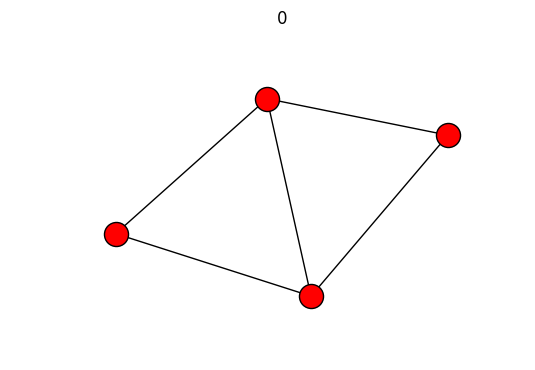

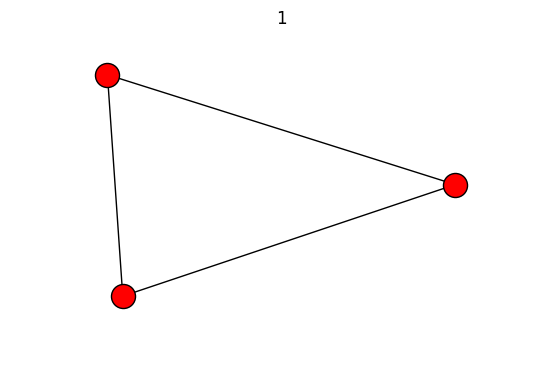

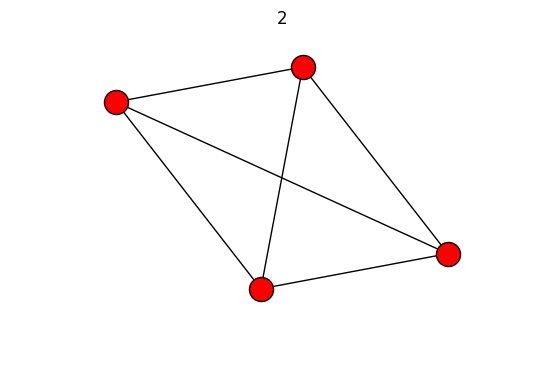

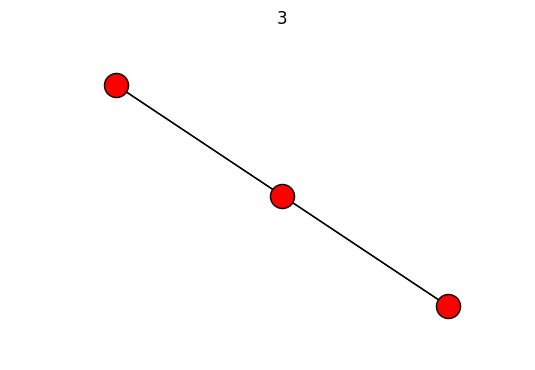

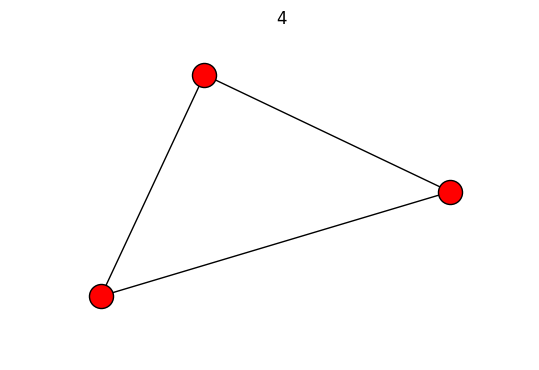

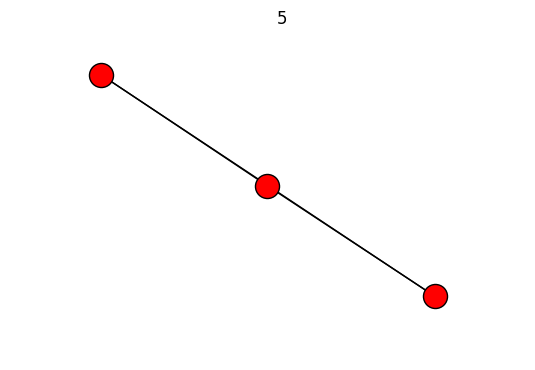

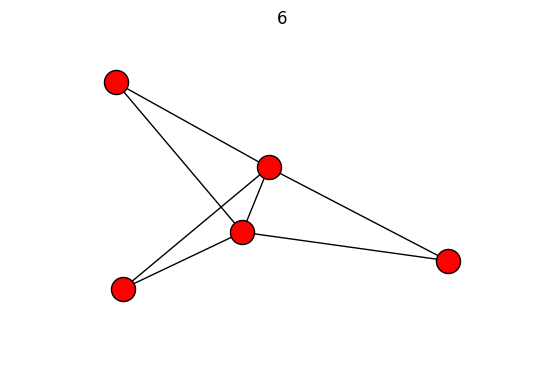

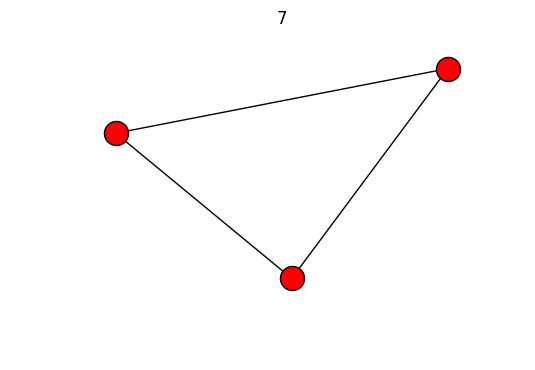

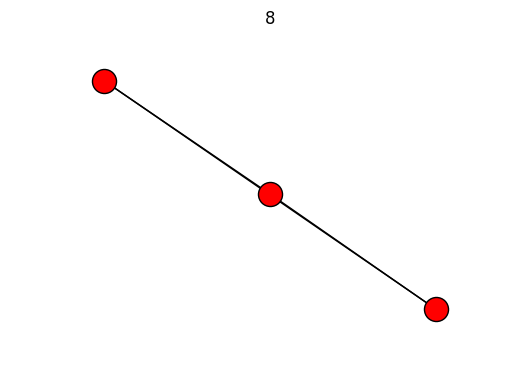

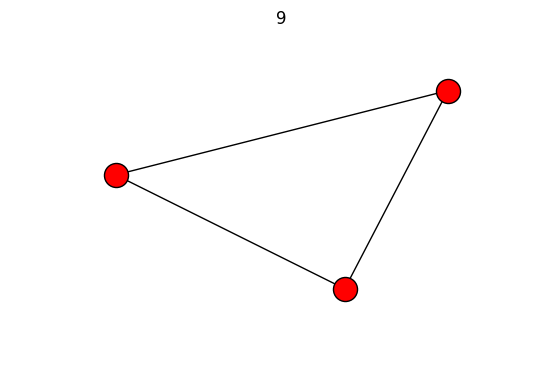

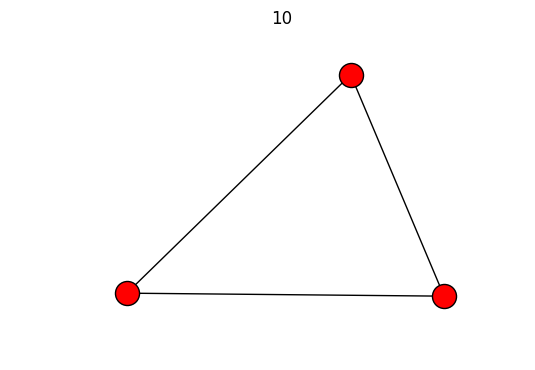

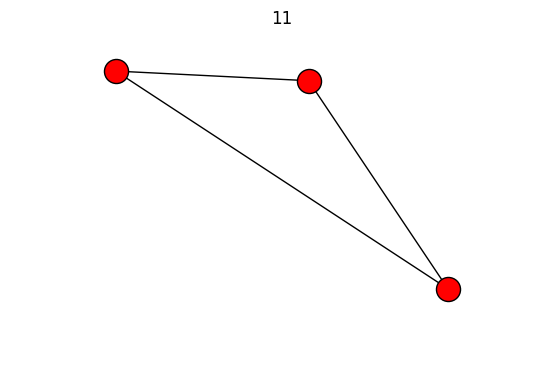

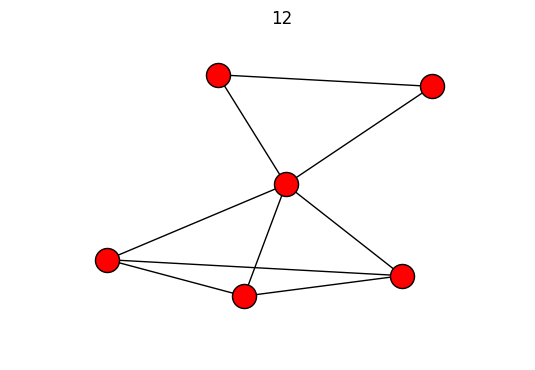

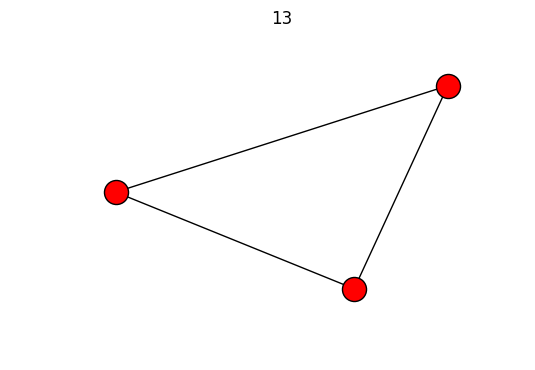

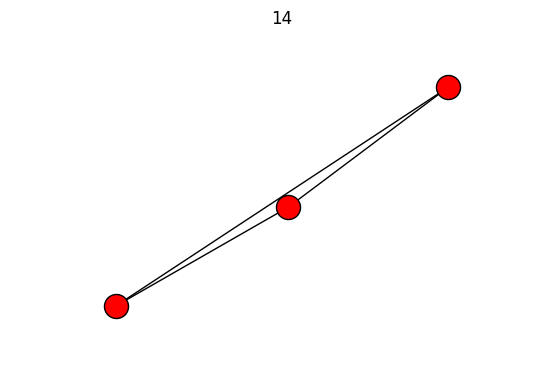

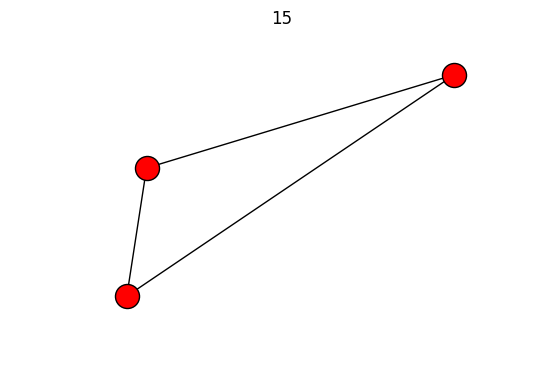

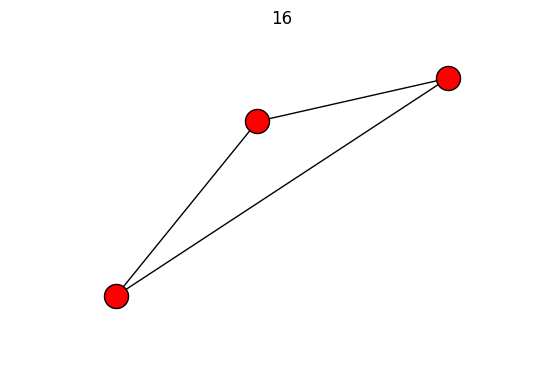

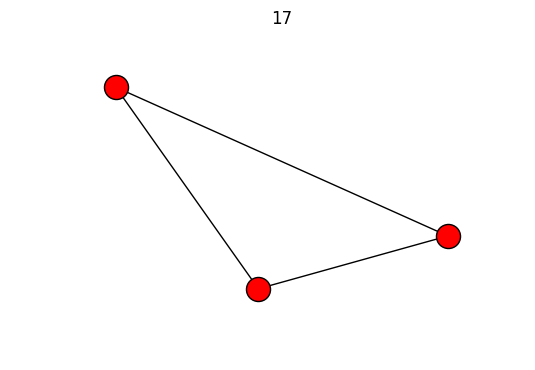

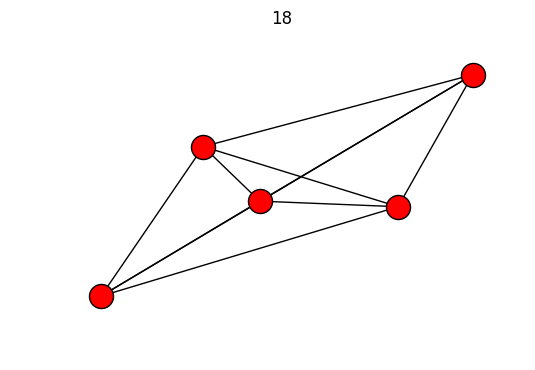

In [759]:
reducedCommsOfInterest = []
for i, commIndex in enumerate(commsOfInterest):
    sg = g.subgraph(communityNodes[commIndex[0]])
    sgClustering = nx.clustering(sg)
    reducedComm = [node for node in communityNodes[commIndex[0]]\
                  if sgClustering[node] > 0]
    if len(reducedComm) > 0 and nx.number_connected_components(sg.subgraph(reducedComm)) == 1:
        reducedCommsOfInterest.append(reducedComm)


for i, comm in enumerate(reducedCommsOfInterest):
    sg = g.subgraph(comm)
    plt.figure()
    print str(i) + '\n' + str(nx.clustering(sg)) + '\n'
    plt.title(i)
    nx.draw(sg, pos=nx.fruchterman_reingold_layout(sg))

In [414]:
'''
for i, commIndex in enumerate(commsOfInterest):
    sg = g.subgraph(communityNodes[commIndex[0]])
    sg.graph['overlap'] = 'scale'
    plt.figure()
    plt.title(str(i) + '\n' + str(nx.average_clustering(sg)))
    nx.draw(sg, labels = nx.clustering(sg), pos=nx.fruchterman_reingold_layout(sg))
'''

"\nfor i, commIndex in enumerate(commsOfInterest):\n    sg = g.subgraph(communityNodes[commIndex[0]])\n    sg.graph['overlap'] = 'scale'\n    plt.figure()\n    plt.title(str(i) + '\n' + str(nx.average_clustering(sg)))\n    nx.draw(sg, labels = nx.clustering(sg), pos=nx.fruchterman_reingold_layout(sg))\n"

In [760]:
completedCommsOfInterest = []
for comm in reducedCommsOfInterest:
    commFriendsLevel1 = {f['userID']: f['friends'] \
                         for f in friends.find({'userID': {'$in': comm}})\
                        }
    graphCommFriendsLevel1 = nx.from_dict_of_lists(commFriendsLevel1)
    
    completedCommsOfInterest.append([node for node in graphCommFriendsLevel1.nodes() \
     if nx.clustering(graphCommFriendsLevel1)[node] > 0])

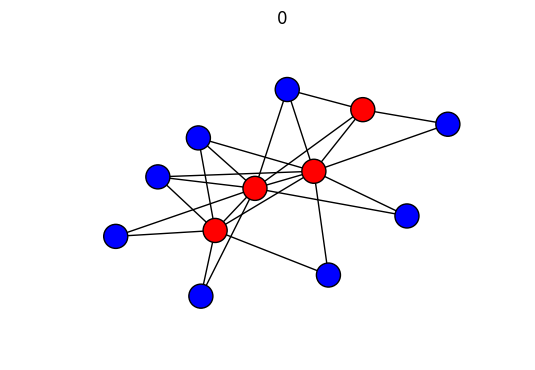

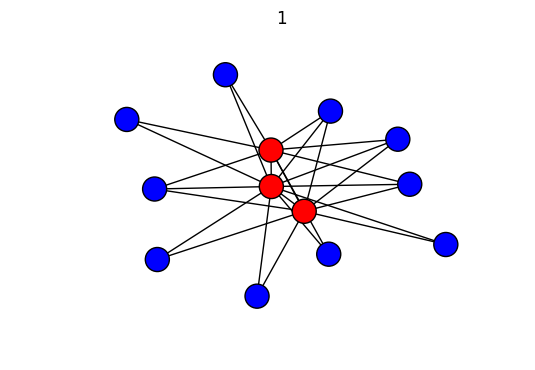

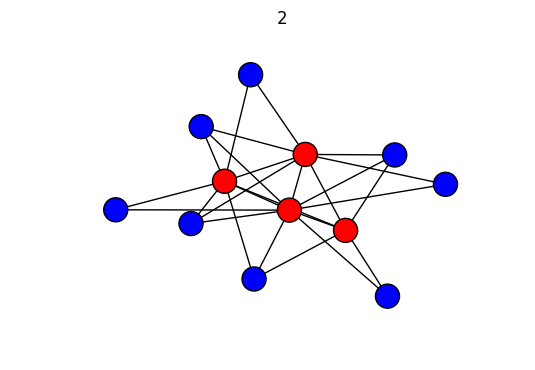

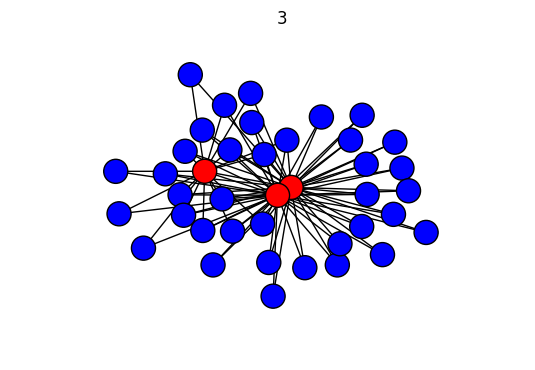

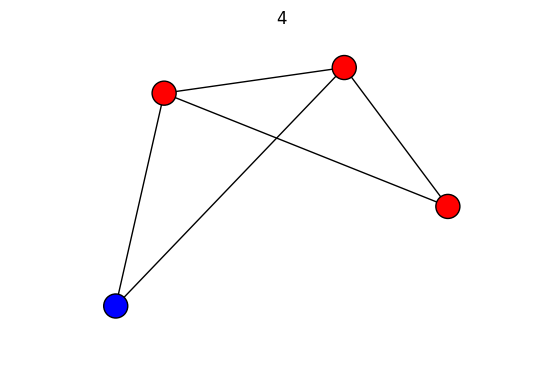

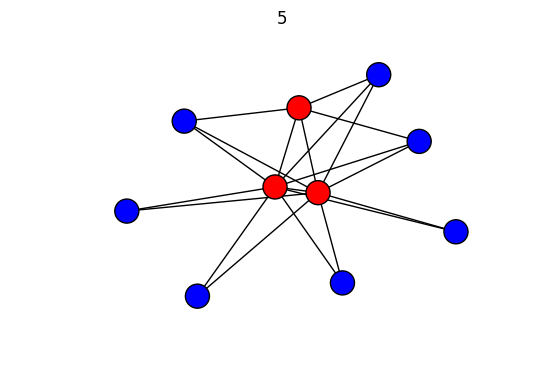

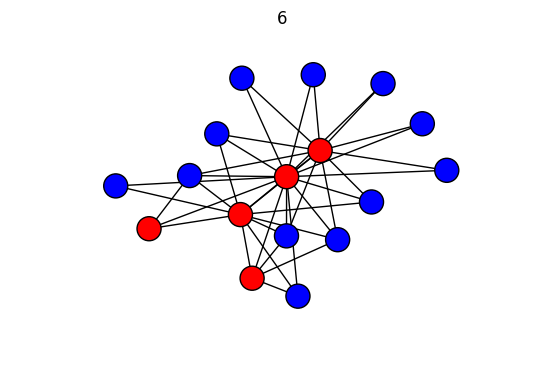

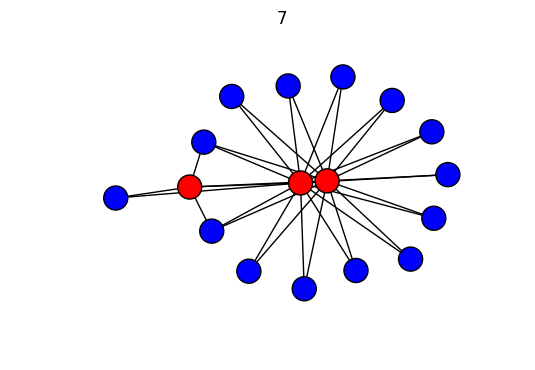

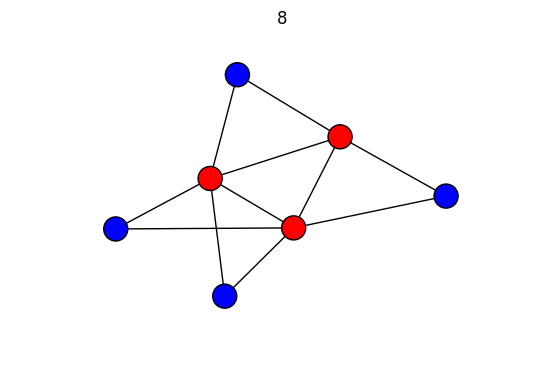

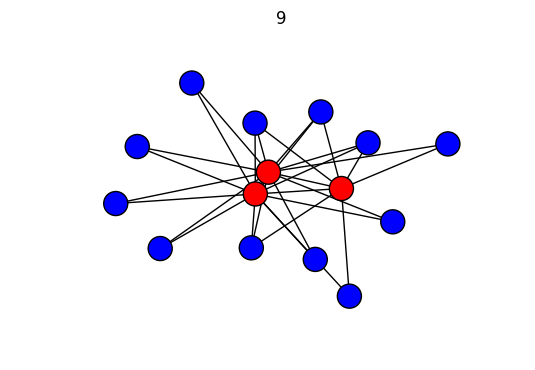

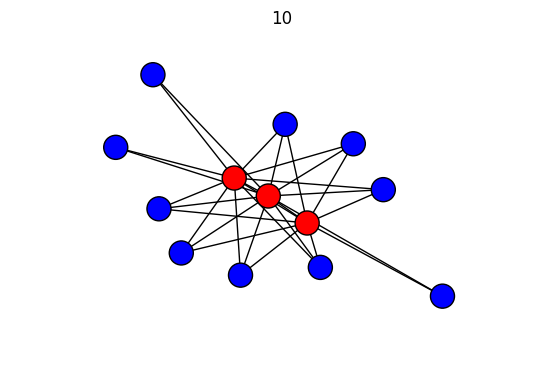

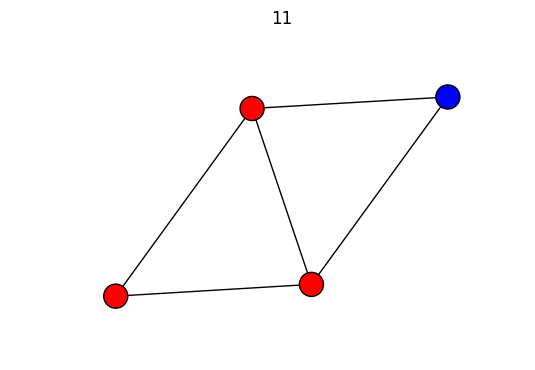

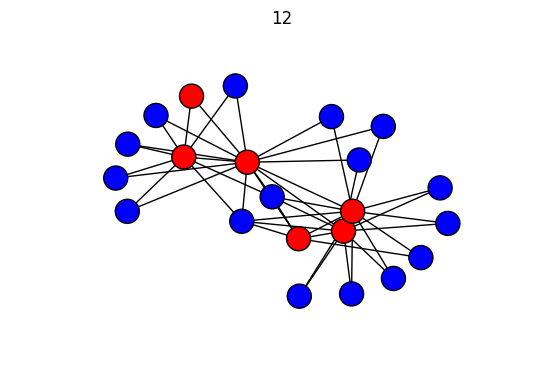

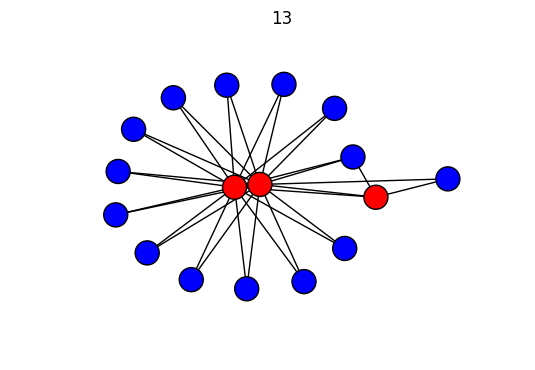

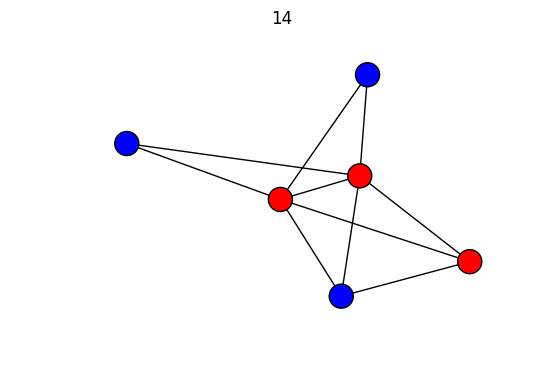

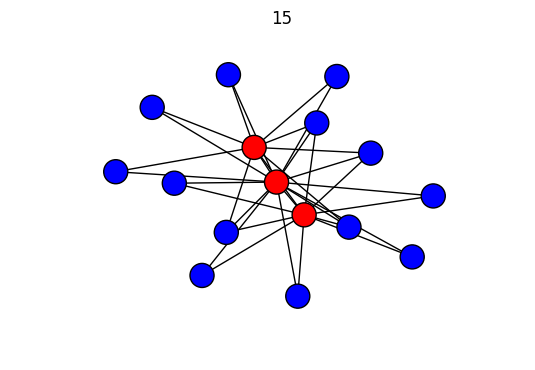

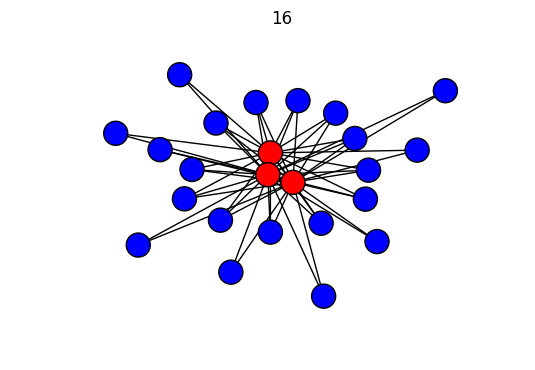

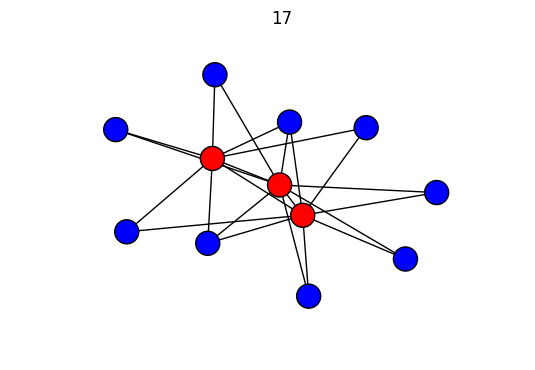

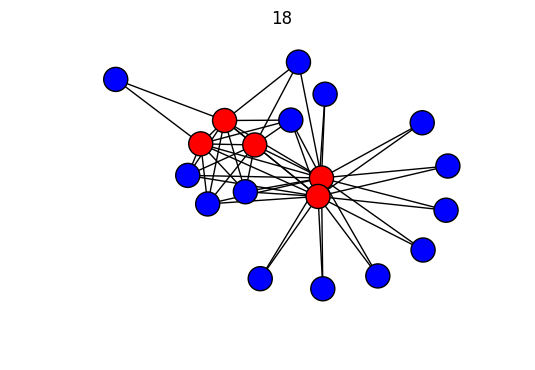

In [761]:
for i, (comm1, comm2) in enumerate(zip(reducedCommsOfInterest, completedCommsOfInterest)):
    commFriendsLevel1 = {f['userID']: f['friends'] \
                         for f in friends.find({'userID': {'$in': comm1}})\
                        }
    graphCommFriendsLevel1 = nx.from_dict_of_lists(commFriendsLevel1)
    sg = graphCommFriendsLevel1.subgraph(comm2)
    colorDict = {True: 'r', False: 'b'}
    
    plt.figure()
    plt.title(i)
    nx.draw(sg, pos=nx.fruchterman_reingold_layout(sg), \
            node_color = [colorDict[node in comm1] for node in sg.nodes()]\
           )

In [762]:
dbFromBook['comms'].delete_many({});
dbFromBook['comms'].insert_one({'comms': completedCommsOfInterest});

In [763]:
dbFromBook.collection_names()

[u'adj_dict',
 u'books',
 u'commBooks',
 u'commFriends',
 u'commRatings',
 u'comms',
 u'friends',
 u'reviews',
 u'system.indexes']

In [764]:
books = dbFromBook['commBooks']
ratings = dbFromBook['commRatings']
friends = dbFromBook['commFriends']

print books.count()
print ratings.count()
print sum([len(comm) for comm in completedCommsOfInterest])

6326
65
280


In [571]:
commRatingMeans = []
for commIndex in completedCommsOfInterest:
    commRatings = []
    for r in ratings.find({'userID': {'$in': commIndex}}):
        if str(focalBookID) in r['ratings']:
            commRatings.append(r['ratings'][str(focalBookID)][0])
    commRatingMeans.append(np.mean(commRatings))

In [869]:
commSets = [set(comm) for comm in completedCommsOfInterest]

for j, b in enumerate(dbFull['books'].find()):
    bookID = b['bookID']
    ratingSet = set([int(k) for k in b['ratings'].keys()])
    commsOfRaters = [i for i, comm in enumerate(commSets)\
                    if len(comm & ratingSet) > 0]
    dbFull['books'].update_one(
            {"bookID": bookID},
            {"$set": {'commsOfRaters': commsOfRaters}},
            upsert=True)
    if j % 1000 == 0:
        print float(j) / dbFull['books'].count()

0.0
0.0147338333014
0.0294676666028
0.0442014999042
0.0589353332056
0.0736691665071
0.0884029998085
0.10313683311
0.117870666411
0.132604499713
0.147338333014
0.162072166316
0.176805999617
0.191539832918
0.20627366622
0.221007499521
0.235741332823
0.250475166124
0.265208999425
0.279942832727
0.294676666028
0.30941049933
0.324144332631
0.338878165932
0.353611999234
0.368345832535
0.383079665837
0.397813499138
0.412547332439
0.427281165741
0.442014999042
0.456748832344
0.471482665645
0.486216498947
0.500950332248
0.515684165549
0.530417998851
0.545151832152
0.559885665454
0.574619498755
0.589353332056
0.604087165358
0.618820998659
0.633554831961
0.648288665262
0.663022498563
0.677756331865
0.692490165166
0.707223998468
0.721957831769
0.736691665071
0.751425498372
0.766159331673
0.780893164975
0.795626998276
0.810360831578
0.825094664879
0.83982849818
0.854562331482
0.869296164783
0.884029998085
0.898763831386
0.913497664687
0.928231497989
0.94296533129
0.957699164592
0.972432997893
0.987

In [910]:
booksToExclude = set()
booksToInclude = set()

for b in books.find():
    if len(b['commsOfRaters']) < 2 or len(b['ratings']) < 10:
        booksToExclude.add(b['bookID'])
    else:
        booksToInclude.add(b['bookID'])

In [911]:
print len(booksToExclude)
print len(booksToInclude)
print ratings.count()

67318
553
355


In [912]:
nUserCounts = []
for i, row in enumerate(ratings.find()):
    nUserCounts.append(len(row['ratings']))
    
nBookCounts = []
bookIDlist = []
for i, row in enumerate(books.find({'bookID': {'$in': list(booksToInclude)}})):
    nBookCounts.append(len(row['ratings']))
    bookIDlist.append(row['bookID'])

In [913]:
nUserCounts = pd.Series(nUserCounts)
nBookCounts = pd.Series(nBookCounts)

print nBookCounts.describe()

count    553.000000
mean      20.106691
std       14.703883
min       10.000000
25%       11.000000
50%       15.000000
75%       23.000000
max      119.000000
dtype: float64


(0, 35)

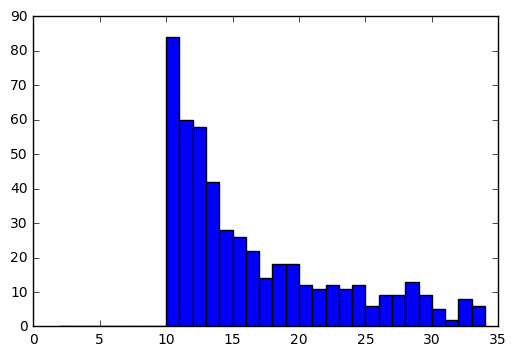

In [914]:
plt.hist(nBookCounts,range(2,35));
plt.xlim(0,35)

In [915]:
glRatingDict = makeRatingDictForGL(ratings, booksToExclude)
glRatings = gl.SFrame(glRatingDict)

In [916]:
glRatingsTrain, glRatingsTest = gl.recommender.util.random_split_by_user(glRatings, 
                                                    user_id="userID", 
                                                    item_id="bookID")

In [917]:
nTrainObs = glRatingsTrain.shape[0]
nTrainUsers = len(glRatingsTrain['userID'].unique())
nTrainItems = len(glRatingsTrain['bookID'].unique())

print nTrainObs, nTrainUsers, nTrainItems

for n in range(1,9):
    print nTrainObs / (n*float(nTrainUsers + nTrainItems))

14630 331 553
16.5497737557
8.27488687783
5.51659125189
4.13744343891
3.30995475113
2.75829562594
2.36425339367
2.06872171946


In [918]:
for i in range(len(completedCommsOfInterest)):
    commratings = \
    np.array([row['rating'] for row in glRatingsTrain if row['userID'] in completedCommsOfInterest[i]])
    print (i, len(completedCommsOfInterest[i]), len(commratings))

(0, 12, 504)
(1, 13, 703)
(2, 12, 210)
(3, 40, 829)
(4, 4, 121)
(5, 10, 334)
(6, 17, 599)
(7, 17, 680)
(8, 7, 208)
(9, 15, 246)
(10, 13, 619)
(11, 4, 93)
(12, 22, 588)
(13, 17, 490)
(14, 6, 151)
(15, 16, 894)
(16, 24, 655)
(17, 12, 321)
(18, 19, 690)


In [789]:
clientJest = MongoClient("mongodb://35.163.255.3")
dbJest = clientJest['goodreads_explore_from_book_jest']

clientUlysses = MongoClient("mongodb://35.161.242.150")
dbUlysses = clientUlysses['goodreads_explore_from_book_ulysses']

clientAtlas = MongoClient("mongodb://35.161.154.87")
dbAtlas = clientAtlas['goodreads_explore_from_book_atlas']

clientManifesto = MongoClient("mongodb://35.160.173.218")
dbManifesto = clientManifesto['goodreads_explore_from_book_manifesto']

dbList = [dbJest, dbUlysses, dbAtlas, dbManifesto]

71038


In [828]:
books.find_one({'bookID': int(ratings.find_one()['ratings'].keys()[0])})

{u'_id': ObjectId('5833403cae0a79b494b90c49'),
 u'bookID': 18194,
 u'commsOfRaters': [0],
 u'ratings': {u'146050': [0, u'Jan 2003', u'Jun 22, 2007'],
  u'147144': [3, u'not set', u'Jun 22, 2007']}}

In [830]:
dbFull = client['goodreads_full']
friendsFull = dbFull['friends']
ratingsFull = dbFull['ratings']
booksFull = dbFull['books']

friends = friendsFull
ratings = ratingsFull
books = booksFull

#friendsFull.insert_many(dbJest['friends'].find())
#friendsFull.insert_many(dbUlysses['friends'].find())
#friendsFull.insert_many(dbAtlas['friends'].find())
#friendsFull.insert_many(dbManifesto['friends'].find())

for db in dbList:
    for i, r in enumerate(db['commRatings'].find()):
        if ratings.find({'userID': r['userID']}).count() == 0:
            ratings.insert_one(r)
        for bookID in r['ratings'].keys():
            if books.find({'bookID': int(bookID)}).count() == 0:
                b = db['commBooks'].find_one({'bookID': int(bookID)})
                if b is not None:
                    books.insert_one(b)
        if i % 10 == 0:
            print i
    '''
    for b in db['commBooks'].find():
        if books.find({'bookID': b['bookID']}).count() == 0:
            books.insert_one(b)
        if books.count() % 1000 == 0:
            print float(books.count()) / sum([db['commBooks'].count() for db in dbList])
    '''

0
10
20
30
40
50
60
0
10
20
0
10
20
30
0
10
20
30


In [833]:
dbFull['comms'].delete_many({});
dbFull['comms'].insert_one({'comms': completedCommsOfInterest});

In [868]:
print sum([len(comm) for comm in completedCommsOfInterest])
print ratings.count()

280
355


In [90]:
rec_engine_8 = gl.factorization_recommender.create(   observation_data=glRatingsTrain, 
                                                    user_id="userID", 
                                                    item_id="bookID", 
                                                    target='rating',
                                                    num_factors=8,
                                                    solver='auto',
                                                    max_iterations=1000,                                                  max_iterations=1000,
                                                    regularization = 1e-12,
                                                    linear_regularization = 1
                                                    )

SyntaxError: keyword argument repeated (<ipython-input-90-2a5669fd64c7>, line 7)

In [ ]:
print rec_engine_8.evaluate_rmse(glRatingsTest, target='rating')['rmse_overall']
print rec_engine_8.evaluate_rmse(glRatingsTest, target='rating')['rmse_overall'] - rec_engine_baseline.evaluate_rmse(glRatingsTest, target='rating')['rmse_overall']

In [33]:
rec_engine = rec_engine_8

bookWeightings = rec_engine.get('coefficients')['bookID']
npBookWeightings = bookWeightings['factors'].to_numpy()
for i, row in enumerate(npBookWeightings):
    npBookWeightings[i,:] /= np.linalg.norm(row)
bookWeightings['factors'] = gl.SArray(npBookWeightings)
bookWeightings = bookWeightings.unpack('factors')

In [52]:
bookWeightings.sort('factors.0', ascending=False)['factors.0'][50]

0.9777261449253141

In [55]:
print '\n'.join([bookTitle(int(bID)) 
                 for bID in bookWeightings.sort('factors.0', ascending=False)['bookID'][:100]
                 if len(books.find_one({'bookID': int(bID)})['ratings']) > 20])
print '------'
print '\n'.join([bookTitle(int(bID)) 
                 for bID in bookWeightings.sort('factors.0', ascending=True)['bookID'][:100]
                 if len(books.find_one({'bookID': int(bID)})['ratings']) > 20])

Flow My Tears, the Policeman Said
The Left Hand of Darkness
      
          (Hainish Cycle #6)
On Beauty
Dance Dance Dance
      
          (The Rat #4)
The Mote in God's Eye
      
          (Moties #1)
Labyrinths:  Selected Stories and Other Writings
------
Swann's Way
      
          (À la recherche du temps perdu #1)
Exodus


In [59]:
print '\n'.join([bookTitle(int(bID)) 
                 for bID in bookWeightings.sort('factors.1', ascending=False)['bookID'][:100]
                 if len(books.find_one({'bookID': int(bID)})['ratings']) > 20])
print '------'
print '\n'.join([bookTitle(int(bID)) 
                 for bID in bookWeightings.sort('factors.1', ascending=True)['bookID'][:100]
                 if len(books.find_one({'bookID': int(bID)})['ratings']) > 20])

The Taming of the Shrew
Mansfield Park
The Power and the Glory
------
To Say Nothing of the Dog
      
          (Oxford Time Travel #2)
A History of the World in 10½  Chapters


In [61]:
print '\n'.join([bookTitle(int(bID)) 
                 for bID in bookWeightings.sort('factors.2', ascending=False)['bookID'][:100]
                 if len(books.find_one({'bookID': int(bID)})['ratings']) > 10])
print '------'
print '\n'.join([bookTitle(int(bID)) 
                 for bID in bookWeightings.sort('factors.2', ascending=True)['bookID'][:100]
                 if len(books.find_one({'bookID': int(bID)})['ratings']) > 10])

Waiting
The War of the Worlds
The Sandman, Vol. 2: The Doll's House
      
          (The Sandman #2)
------



In [57]:
print '\n'.join([bookTitle(int(bID)) 
                 for bID in bookWeightings.sort('factors.3', ascending=False)['bookID'][:100]
                 if len(books.find_one({'bookID': int(bID)})['ratings']) > 20])
print '------'
print '\n'.join([bookTitle(int(bID)) 
                 for bID in bookWeightings.sort('factors.3', ascending=True)['bookID'][:100]
                 if len(books.find_one({'bookID': int(bID)})['ratings']) > 20])

Player Piano
The Snows of Kilimanjaro and Other Stories
------
The Time Traveler's Wife
The Silence of the Lambs
      
          (Hannibal Lecter #2)
Foundation's Edge
      
          (Foundation (Publication Order) #4)


In [58]:
print '\n'.join([bookTitle(int(bID)) for bID in bookWeightings.sort('factors.3', ascending=False)['bookID'][:5]])
print '------'
print '\n'.join([bookTitle(int(bID)) for bID in bookWeightings.sort('factors.3', ascending=True)['bookID'][:5]])

Casino Moon
Out on the Rim
      
          (Arthur Case Wu #2)
Outsider in Amsterdam
      
          (Amsterdam Cops Mysteries #1)
Dark Canyon
What's Not to Love?: The Adventures of a Mildly Perverted Young Writer
------
Hidden History: Exploring Our Secret Past
Among the Believers : An Islamic Journey
The Bottoms
American Scream
Fenwick Travers and the Years of Empire: An Entertainment


In [21]:
dfBookWeightings = bookWeightings.to_dataframe()

In [22]:
dfBookWeightings[dfBookWeightings['bookID']==str(focalBookID)]

,bookID,linear_terms,factors.0,factors.1,factors.2,factors.3
11,118154,0.154152,0.347579,0.171606,0.851917,0.352106


In [23]:
userWeightings = rec_engine.get('coefficients')['userID'].unpack('factors')

In [24]:
dfUserWeightings = userWeightings.to_dataframe()

In [62]:
dfUserWeightings[dfUserWeightings['userID']==7607437] #N.R.

,userID,linear_terms,factors.0,factors.1,factors.2,factors.3
7,7607437,0.759385,0.278522,-0.682661,0.481648,0.093921


In [235]:
targetTruth = glRatingsTest[glRatingsTest['bookID'] == str(focalBookID)]

(15, 3)

In [61]:
targetPreds = barthTruth['userID','rating'].add_column(rec_engine.predict(targetTruth), name="modelRating")

NameError: name 'rec_engine' is not defined

In [366]:
evalTarget = rec_engine.evaluate_rmse(targetTruth, target='rating')
print evalTarget['rmse_overall']
print evalTarget['rmse_overall'] - eval['rmse_overall']

0.888040534664
-0.0348179848496


In [11]:
allFriendIDs = reduce(lambda l1, l2: l1+l2, [f['friends'] for f in friends.find()])

In [12]:
len(allFriendIDs) - len(set(allFriendIDs))

7651

In [17]:
df = pd.DataFrame([userIDlist, list(friendCounts)]).T
friendLocs = df.iloc[:,0][df.iloc[:,1]>0]

In [18]:
fullTargetTruth = glRatings[glRatings['bookID'] == str(focalBookID)]
fullTargetTruthDf = fullTargetTruth.to_dataframe()
fullTargetTruthDf.set_index('userID',inplace=True)
fullTargetTruthDf['rating'].describe()

NameError: name 'glRatings' is not defined

In [19]:
fullTargetTruthDf.loc[friendLocs,:]

NameError: name 'fullTargetTruthDf' is not defined